In [3]:
import os
import zipfile

dataset_dir = '/kaggle/working/datasets/VisDrone'
test_dev_url = 'https://github.com/ultralytics/yolov5/releases/download/v1.0/VisDrone2019-DET-test-dev.zip'
zip_path = os.path.join(dataset_dir, 'VisDrone2019-DET-test-dev.zip')

# Create the datasets/VisDrone folder if it does not exist
os.makedirs(dataset_dir, exist_ok=True)

# Download the zip file if it is not already there
if not os.path.exists(zip_path):
    !wget -q -P {dataset_dir} {test_dev_url}
    print("Download completato.")
else:
    print("Archivio zip già presente.")

# Extracts files
extract_path = os.path.join(dataset_dir, 'VisDrone2019-DET-test-dev')
if not os.path.exists(extract_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(dataset_dir)
else:
    print("Dataset già estratto.")

test_images_path = os.path.join(extract_path, 'images')
print(f" Percorso immagini di test: {test_images_path}")

Download completato.
 Percorso immagini di test: /kaggle/working/datasets/VisDrone/VisDrone2019-DET-test-dev/images


In [4]:
import os
import glob
from PIL import Image
from tqdm.notebook import tqdm

# Route configuration
base_path = '/kaggle/working/datasets/VisDrone/VisDrone2019-DET-test-dev'
images_path = os.path.join(base_path, 'images') # mage Folder
annotations_path = os.path.join(base_path, 'annotations') # Original Notes Folder
labels_path = os.path.join(base_path, 'labels') # Label Folder Generated

# Create the labels folder if it does not exist
os.makedirs(labels_path, exist_ok=True)

# Visdrone class map -> YOLO (0-9)
# VisDrone classes: 0:ignored, 1:pedestrian, 2:people, 3:bicycle, 4:car, 5:van, 
#                   6:truck, 7:tricycle, 8:awning-tricycle, 9:bus, 10:motor, 11:others
# Use only 1 to 10, remap from 0 to 9
class_map = {
    1: 0,  # pedestrian
    2: 1,  # people
    3: 2,  # bicycle
    4: 3,  # car
    5: 4,  # van
    6: 5,  # truck
    7: 6,  # tricycle
    8: 7,  # awning-tricycle
    9: 8,  # bus
    10: 9  # motor
}

# Conversion function
def convert_visdrone_to_yolo():
    anno_files = glob.glob(os.path.join(annotations_path, '*.txt'))
    
    if not anno_files:
        print(" ERRORE: Non trovo file .txt nella cartella annotations!")
        return

    print(f" Avvio conversione di {len(anno_files)} file...")

    for anno_file in tqdm(anno_files):
        filename = os.path.basename(anno_file)
        img_filename = filename.replace('.txt', '.jpg')
        img_path = os.path.join(images_path, img_filename)
        
        # Skip if image does not exist
        if not os.path.exists(img_path):
            continue
            
        # 1. Obtained image dimensions (Width, Height)
        with Image.open(img_path) as img:
            img_w, img_h = img.size
            
        # 2. Reading VisDrone annotation
        # Format: <bbox_left>,<bbox_top>,<bbox_width>,<bbox_height>,<score>,<object_category>,<truncation>,<occlusion>
        yolo_lines = []
        with open(anno_file, 'r') as f:
            lines = f.readlines()
            for line in lines:
                data = line.strip().split(',')
                if len(data) < 8: continue
                
                category = int(data[5])
                
                # If the category is among those of interest (1-10)
                if category in class_map:
                    class_id = class_map[category]
                    
                    # Original coordinates
                    x1 = float(data[0])
                    y1 = float(data[1])
                    w = float(data[2])
                    h = float(data[3])
                    
                    # Conversion to YOLO format (Normalised Centre-X, Centre-Y, Width, Height)
                    x_center = (x1 + w / 2) / img_w
                    y_center = (y1 + h / 2) / img_h
                    w_norm = w / img_w
                    h_norm = h / img_h
                    
                    # Clipping for safety (0-1)
                    x_center = max(0, min(1, x_center))
                    y_center = max(0, min(1, y_center))
                    w_norm = max(0, min(1, w_norm))
                    h_norm = max(0, min(1, h_norm))
                    
                    yolo_lines.append(f"{class_id} {x_center:.6f} {y_center:.6f} {w_norm:.6f} {h_norm:.6f}")
        
        # 3. Writing the .txt file in the LABELS folder
        dest_path = os.path.join(labels_path, filename)
        with open(dest_path, 'w') as f_out:
            f_out.write('\n'.join(yolo_lines))

# Conversion
convert_visdrone_to_yolo()

 Avvio conversione di 1610 file...


  0%|          | 0/1610 [00:00<?, ?it/s]

In [3]:
!pip install ultralytics

import os
import yaml
import gc
import torch
import pandas as pd
from ultralytics import YOLO

# 1. Model configuration
models_to_test = {
    'YOLOv8s_100':    '/kaggle/input/pesiyolo-visdrone/v8small_100.pt',       
    'YOLOv8s_50':     '/kaggle/input/pesiyolo-visdrone/v8small_50.pt',       
    'YOLOv8s_25':     '/kaggle/input/pesiyolo-visdrone/v8small_25.pt',       

    'YOLOv10s_100':   '/kaggle/input/pesiyolo-visdrone/v10small_100.pt', 
    'YOLOv10s_50':    '/kaggle/input/pesiyolo-visdrone/v10small_50.pt',      
    'YOLOv10s_25':    '/kaggle/input/pesiyolo-visdrone/v10small_25.pt',      
    'YOLOv10s_100_1024':   '/kaggle/input/pesiyolo-visdrone/v10small_100_1024.pt', 

    'YOLOv10n_100':   '/kaggle/input/pesiyolo-visdrone/v10nano_100.pt', 
    'YOLOv10n_nms_100': '/kaggle/input/nmsresults/v10nano_nms_100.pt', 
}

# 2. Definition of configurations to be tested
configs_to_run = [
    { 'imgsz': 640,  'batch': 16, 'desc': 'Standard' },  
    { 'imgsz': 1024, 'batch': 16,  'desc': 'HighRes' },  
    { 'imgsz': 1280, 'batch': 16,  'desc': 'UltraRes' }, 
    { 'imgsz': 1600, 'batch': 16,  'desc': 'Extreme' } 
]


# 3. Setup dataset (yaml)
visdrone_classes = {
    0: 'pedestrian', 1: 'people', 2: 'bicycle', 3: 'car', 4: 'van',
    5: 'truck', 6: 'tricycle', 7: 'awning-tricycle', 8: 'bus', 9: 'motor'
}

test_images_rel_path = 'VisDrone2019-DET-test-dev/images'
custom_yaml = {
    'path': '/kaggle/working/datasets/VisDrone',
    'train': test_images_rel_path,    
    'val': test_images_rel_path,      
    'test': test_images_rel_path,      
    'names': visdrone_classes
}

yaml_filename = 'VisDrone_Test_Only.yaml'
with open(yaml_filename, 'w') as f:
    yaml.dump(custom_yaml, f)


# 4. Dynamic evaluation loop 
results_list = []

print(f" Avvio Benchmark Multi-Configurazione...")
print(f" Modelli: {len(models_to_test)}")
print(f" Configurazioni: {len(configs_to_run)}")
print("="*80)

for config in configs_to_run:
    current_imgsz = config['imgsz']
    current_batch = config['batch']
    desc = config['desc']
    
    print(f"\n AVVIO CONFIGURAZIONE: {desc} (Size: {current_imgsz}, Batch: {current_batch})")
    print("-" * 50)
    
    for model_name, weights_path in models_to_test.items():
        print(f" Testing: {model_name} @ {current_imgsz}px ...")
        
        # GPU memory clean-up
        gc.collect()
        torch.cuda.empty_cache()
        
        try:
            model = YOLO(weights_path)
            
            # Validation parameters
            run_params = {
                'data': yaml_filename,
                'split': 'test',
                'imgsz': current_imgsz,
                'batch': current_batch,
                'project': 'Benchmark_Finale',
                'name': f"{model_name}_{current_imgsz}",
                'verbose': True,
                'save_json': True,
                'plots': True
            }

            # 1. Perform validation
            results = model.val(**run_params)

            # 2. Basic data extraction
            entry = {
                'Modello': model_name,
                'ImgSz': current_imgsz,
                'Batch': current_batch,
                'Descrizione': desc,
                'mAP50': results.box.map50,
                'mAP50-95': results.box.map,
                'Precision': results.box.mp,
                'Recall': results.box.mr
            }
        
            # 3. Wxtraction of metrics by class
            try:
                # mAP50-95 for class
                classes_map50_95 = results.box.maps 
                
                # mAP50 for class (Array size error handling)
                # If box.ap is 2D, we take column 0, otherwise we handle the case
                if results.box.ap.ndim == 2:
                    classes_map50 = results.box.ap[:, 0]
                else:
                    # Fallback in case the array is odd/flat
                    classes_map50 = [0.0] * len(results.names) 
            
                # Loop on classes
                for class_id, class_name in results.names.items():
                    # mAP 50-95
                    if len(classes_map50_95) > class_id:
                        entry[f'{class_name}_mAP50-95'] = classes_map50_95[class_id]
                    else:
                        entry[f'{class_name}_mAP50-95'] = 0.0

                    # mAP 50
                    if len(classes_map50) > class_id:
                        entry[f'{class_name}_mAP50'] = classes_map50[class_id]
                    else:
                        entry[f'{class_name}_mAP50'] = 0.0
                        
            except Exception as e_class:
                print(f" Warning: Impossibile estrarre dettagli classi ({e_class}). Salvo solo globali.")

            #4. Add to the final list
            results_list.append(entry)
            print(f" OK! mAP(50-95): {results.box.map:.4f}")

        except Exception as e:
            print(f" ERRORE CRITICO con {model_name}: {e}")
            results_list.append({
                'Modello': model_name,
                'ImgSz': current_imgsz,
                'Batch': current_batch,
                'Descrizione': "ERRORE",
                'mAP50': 0.0, 'mAP50-95': 0.0, 'Precision': 0.0, 'Recall': 0.0
            })
            gc.collect()
            torch.cuda.empty_cache()


# 5. Final aggregate table

df_results = pd.DataFrame(results_list)

base_cols = ['Modello', 'ImgSz', 'Batch', 'mAP50-95', 'mAP50', 'Recall', 'Precision']
other_cols = [c for c in df_results.columns if c not in base_cols]
df_results = df_results[base_cols + other_cols]

df_results = df_results.sort_values(by=['ImgSz', 'mAP50-95'], ascending=[True, False])

df_results.to_csv('Risultati_Completi_Classi.csv', index=False)

# Only print the main columns for screen readability
print(df_results[['Modello', 'ImgSz', 'mAP50-95', 'mAP50', 'Recall']].to_string(index=False))
print("="*100)
print("File salvato come: Risultati_Completi_Classi.csv")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 50.9 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
 YAML creato: VisDrone_Test_Only.yaml
 Avvio Benchmark Multi-Configurazione...
 Modelli: 9
 Configurazioni: 4

 AVVIO CONFIGURAZIONE: Standard (Size: 640, Batch: 16)
--------------------------------------------------
 Testing: YOLOv8s_100 @ 640px ...
Ultralytics 8.4.9 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
Model summary (fused): 73 layers, 11,129,454 parameters, 0 gradients, 28.5 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 3019.0±1017.4 MB/s, size: 168.2 KB)
val: Scanning /kaggle/working/datasets/VisDrone/VisDrone2019-DET-test-dev/labels... 1610 images, 0 b


 mAP(50-95) Matrix - Model vs Resolution:
ImgSz                  640       1024      1280      1600
Modello                                                  
YOLOv10n_100       0.153077  0.194279  0.200504  0.193966
YOLOv10n_nms_100   0.130699  0.172946  0.180676  0.173844
YOLOv10s_100       0.194765  0.238318  0.241227  0.232904
YOLOv10s_100_1024  0.188101  0.253796  0.268593  0.270612
YOLOv10s_25        0.146716  0.174902  0.172826  0.161379
YOLOv10s_50        0.176825  0.216539  0.219787  0.207305
YOLOv8s_100        0.193731  0.234022  0.238617  0.228783
YOLOv8s_25         0.151239  0.188233  0.191289  0.179503
YOLOv8s_50         0.170354  0.213736  0.216751  0.207013

 Best mAP50-95:
   🔹 @ 640px: YOLOv10s_100 (mAP: 0.1948)
   🔹 @ 1024px: YOLOv10s_100_1024 (mAP: 0.2538)
   🔹 @ 1280px: YOLOv10s_100_1024 (mAP: 0.2686)
   🔹 @ 1600px: YOLOv10s_100_1024 (mAP: 0.2706)


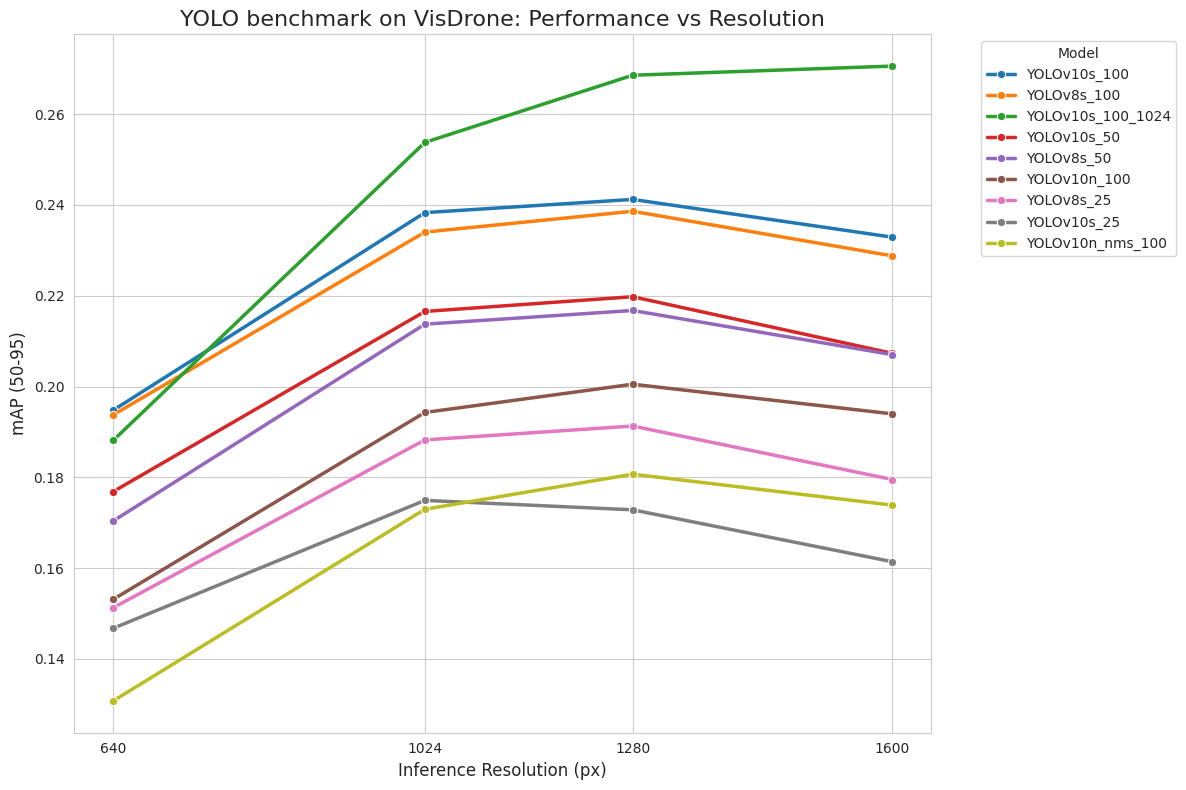

In [4]:
# Automatic analysis, reports and plots
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Comparison matrix (pivot table)
# Table showing how mAP changes as resolution changes
pivot_map = df_results.pivot_table(index='Modello', columns='ImgSz', values='mAP50-95')
print("\n mAP(50-95) Matrix - Model vs Resolution:")
print(pivot_map.to_string(na_rep="-"))

# Save the matrix in CSV format
pivot_map.to_csv('Matrice_Confronto_Modelli.csv')

#2. Select the model with the best result for each resolution.
print("\n Best mAP50-95:")
best_models = df_results.loc[df_results.groupby("ImgSz")["mAP50-95"].idxmax()]

for _, row in best_models.iterrows():
    print(f"   🔹 @ {row['ImgSz']}px: {row['Modello']} (mAP: {row['mAP50-95']:.4f})")

# 3. Plot Generation (Line plot)
try:
    plt.figure(figsize=(12, 8))
    sns.set_style("whitegrid")
    
    sns.lineplot(data=df_results, x='ImgSz', y='mAP50-95', hue='Modello', marker='o', linewidth=2.5)
    
    plt.title('YOLO benchmark on VisDrone: Performance vs Resolution', fontsize=16)
    plt.xlabel('Inference Resolution (px)', fontsize=12)
    plt.ylabel('mAP (50-95)', fontsize=12)
    plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.xticks(configs_to_run[0]['imgsz'] if isinstance(configs_to_run[0], list) else sorted(df_results['ImgSz'].unique()))
    plt.tight_layout()
    
    # Save the plot
    plt.savefig('Grafico_Confronto_mAP.png', dpi=300)
    plt.show()
    
except Exception as e:
    print(f"\n Grafico non creato: {e}")

In [5]:
import os
from IPython.display import FileLink

# 1. Configuration
target_folder = '/kaggle/working/runs'
output_zip = 'tutti_i_risultati_runs.zip'

# 2. Check if the folder exists
if os.path.exists(target_folder):
    print(f" Compressione della cartella '{target_folder}'...")
    
    # Use the system zip command (it is faster and handles nested files better)
    # -r: recursive (all subfolders)
    # -q: quiet (does not fill the screen with text)
    exit_code = os.system(f"zip -r -q {output_zip} {target_folder}")
    
    if exit_code == 0:
        display(FileLink(output_zip))
    else:
        print(" Errore durante la compressione.")
else:
    print(f" La cartella {target_folder} non esiste.")

 Compressione della cartella '/kaggle/working/runs'...


/kaggle/working/tutti_i_risultati_runs.zip

In [9]:
# Benchmark cell cleaning

import shutil
import os

folder_to_clean = '/kaggle/working/runs'

if os.path.exists(folder_to_clean):
    try:
        shutil.rmtree(folder_to_clean)
        print(f" Cartella eliminata con successo: {folder_to_clean}")
    except Exception as e:
        print(f" Errore durante l'eliminazione: {e}")
else:
    print(f" La cartella {folder_to_clean} non esiste (è già pulita).")

✅ Cartella eliminata con successo: /kaggle/working/runs
Ora la cartella 'runs' è pulita. Puoi rilanciare il benchmark.



 Misuro latenza per: YOLOv8s...
Ultralytics 8.4.9 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
Model summary (fused): 73 layers, 11,129,454 parameters, 0 gradients, 28.5 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 3281.7±949.4 MB/s, size: 197.1 KB)
val: Scanning /kaggle/working/datasets/VisDrone/VisDrone2019-DET-test-dev/labels.cache... 1610 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 1610/1610 675.3Mit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 101/101 8.4it/s 12.0s0.1s
                   all       1610      75102      0.453      0.351      0.335      0.194
Speed: 0.5ms preprocess, 3.0ms inference, 0.0ms loss, 1.3ms postprocess per image
 Totale: 4.85ms | Post-Process: 1.32ms | mAP: 0.1937

 Misuro latenza per: YOLOv10s...
Ultralytics 8.4.9 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLOv10s summary (fused): 105 layers, 7,221,870 p

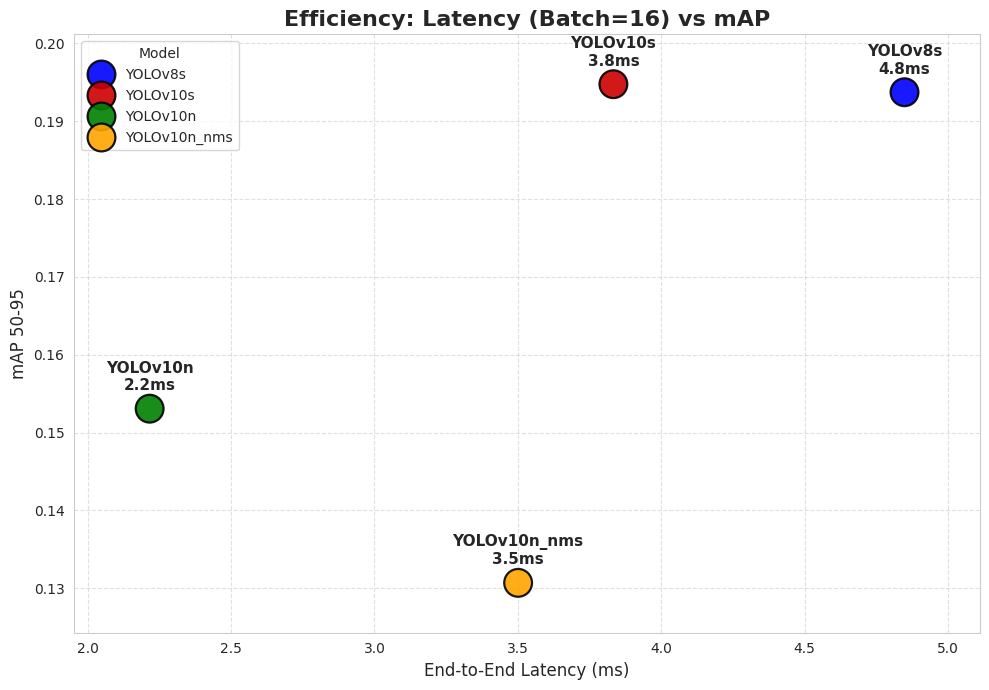

<Figure size 1000x500 with 0 Axes>

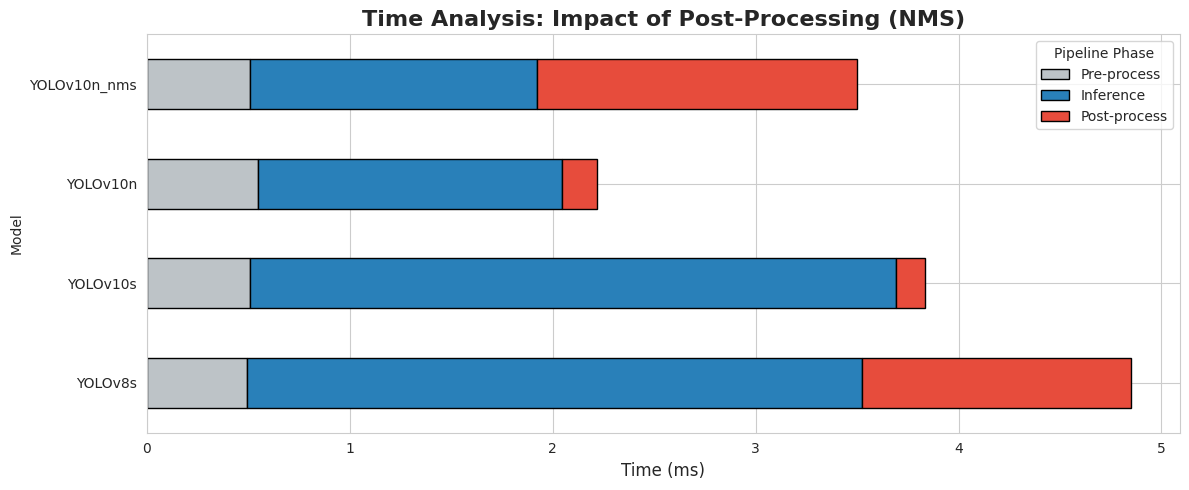

In [5]:
import pandas as pd
import seaborn as sns
import yaml
import matplotlib.pyplot as plt
from ultralytics import YOLO

models_for_latency = {
    'YOLOv8s':    '/kaggle/input/pesiyolo-visdrone/v8small_100.pt',
    'YOLOv10s':   '/kaggle/input/pesiyolo-visdrone/v10small_100.pt',
    'YOLOv10n':   '/kaggle/input/pesiyolo-visdrone/v10nano_100.pt',
    'YOLOv10n_nms':   '/kaggle/input/nmsresults/v10nano_nms_100.pt'
}

visdrone_classes = {
    0: 'pedestrian', 1: 'people', 2: 'bicycle', 3: 'car', 4: 'van',
    5: 'truck', 6: 'tricycle', 7: 'awning-tricycle', 8: 'bus', 9: 'motor'
}

test_images_rel_path = 'VisDrone2019-DET-test-dev/images'
custom_yaml = {
    'path': '/kaggle/working/datasets/VisDrone',
    'train': test_images_rel_path,    
    'val': test_images_rel_path,      
    'test': test_images_rel_path,      
    'names': visdrone_classes
}

yaml_filename = 'VisDrone_Test_Only.yaml'
with open(yaml_filename, 'w') as f:
    yaml.dump(custom_yaml, f)

yaml_file = 'VisDrone_Test_Only.yaml' 

latency_data = []

for model_name, weights_path in models_for_latency.items():
    print(f"\n Misuro latenza per: {model_name}...")
    
    try:
        model = YOLO(weights_path)
        
        # Batch 16
        results = model.val(
            data=yaml_file, 
            split='test', 
            imgsz=640, 
            batch=16, 
            plots=False, 
            verbose=False
        )
        
        speed = results.speed
        t_pre = speed['preprocess']
        t_inf = speed['inference']
        t_post = speed['postprocess'] 
        t_total = t_pre + t_inf + t_post
        
        map_val = results.box.map # mAP50-95
        
        latency_data.append({
            'Model': model_name,
            'mAP': map_val,
            'Latency_Total': t_total,
            'Pre-process': t_pre,
            'Inference': t_inf,
            'Post-process': t_post
        })
        
        print(f" Totale: {t_total:.2f}ms | Post-Process: {t_post:.2f}ms | mAP: {map_val:.4f}")

    except Exception as e:
        print(f" Errore con {model_name}: {e}")

# Plot generation (Scatter + Stacked Bar)

df_lat = pd.DataFrame(latency_data)

if not df_lat.empty:
    sns.set_style("whitegrid")
    
    # Plot 1
    plt.figure(figsize=(10, 7))
    colors = {'YOLOv8s': 'blue', 'YOLOv10s': '#cc0000', 'YOLOv10n': 'green', 'YOLOv10n_nms': 'orange'}
    
    sns.scatterplot(data=df_lat, x='Latency_Total', y='mAP', hue='Model', 
                    palette=colors, s=400, edgecolor='black', alpha=0.9)
    
    for i in range(len(df_lat)):
        row = df_lat.iloc[i]
        plt.text(row['Latency_Total'], row['mAP'] + 0.002, 
                 f"{row['Model']}\n{row['Latency_Total']:.1f}ms", 
                 ha='center', va='bottom', fontweight='bold', fontsize=11)

    plt.title("Efficiency: Latency (Batch=16) vs mAP", fontsize=16, fontweight='bold')
    plt.xlabel("End-to-End Latency (ms)", fontsize=12)
    plt.ylabel("mAP 50-95", fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)
    
    plt.margins(x=0.1, y=0.1)
    plt.tight_layout()
    plt.savefig("Scatter_Latenza_mAP.png", dpi=300)
    plt.show()

    # Plot 2
    plt.figure(figsize=(10, 5))
    
    df_plot = df_lat.set_index('Model')[['Pre-process', 'Inference', 'Post-process']]
    
    df_plot.plot(kind='barh', stacked=True, color=['#bdc3c7', '#2980b9', '#e74c3c'], 
                 edgecolor='black', figsize=(12, 5))
    
    plt.title("Time Analysis: Impact of Post-Processing (NMS)", fontsize=16, fontweight='bold')
    plt.xlabel("Time (ms)", fontsize=12)
    plt.legend(title='Pipeline Phase')
    plt.tight_layout()
    plt.savefig("Analisi_NMS_Stacked_16.png", dpi=300)
    plt.show()
else:
    print("⚠️ Nessun dato raccolto.")

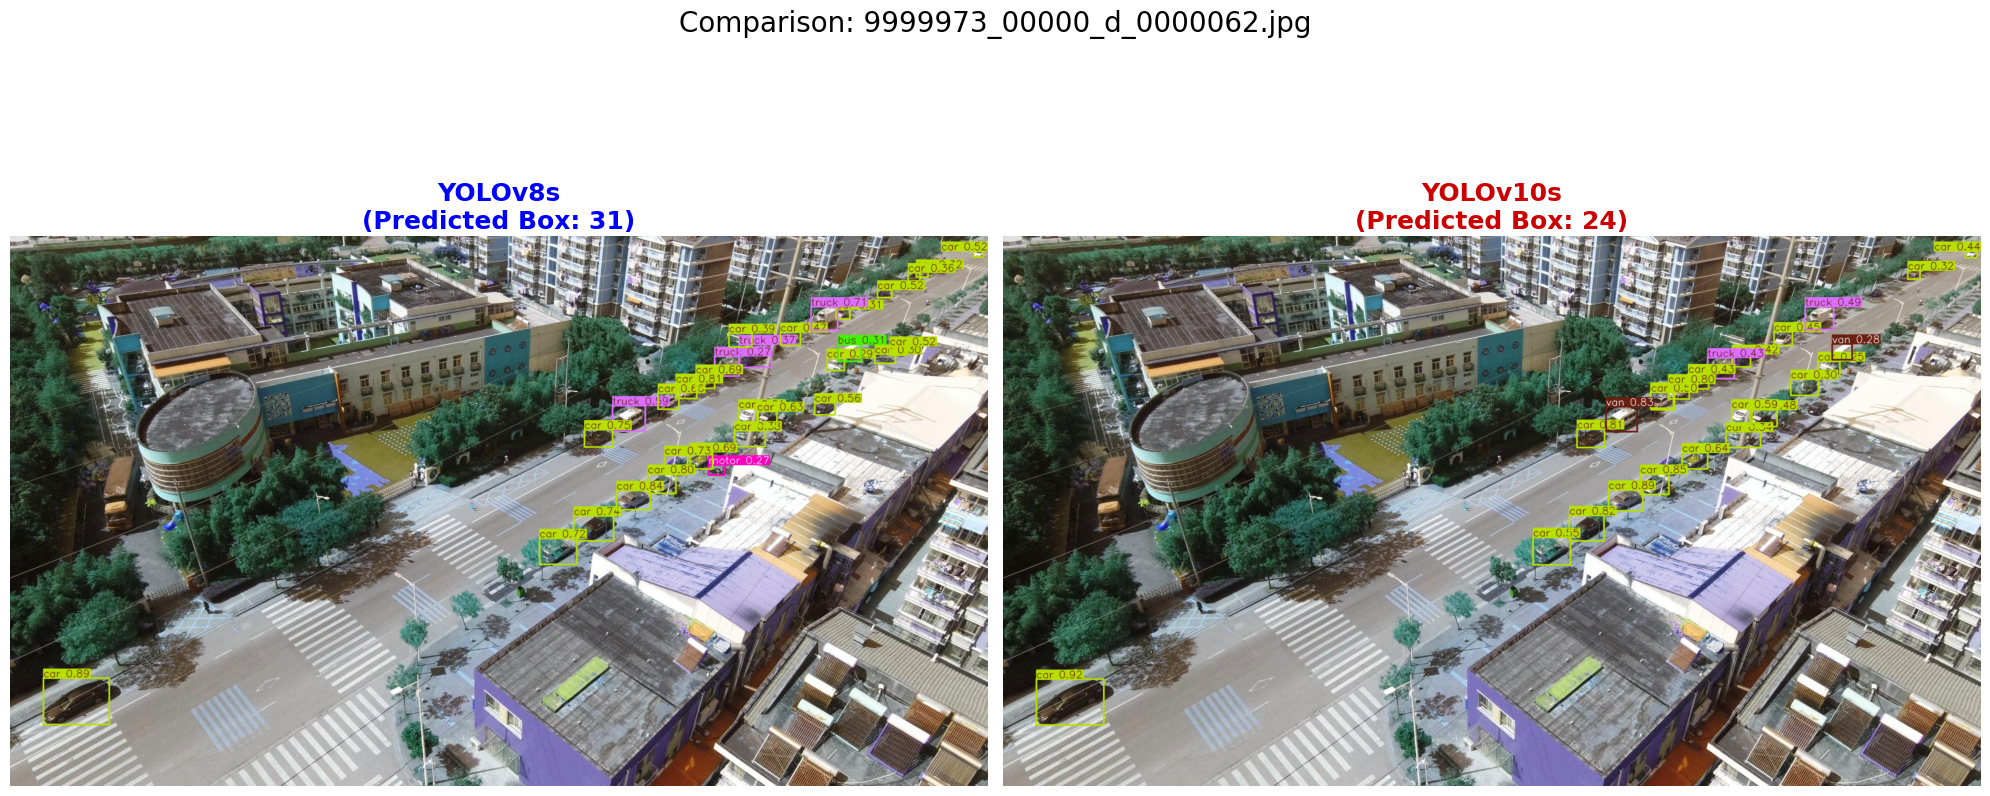

In [8]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
import os
import random
from ultralytics import YOLO

# Configuration
model_v8_path = '/kaggle/input/pesiyolo-visdrone/v8small_100.pt'   
model_v10_path = '/kaggle/input/pesiyolo-visdrone/v10small_100.pt'

# Path of test images 
images_dir = '/kaggle/working/datasets/VisDrone/VisDrone2019-DET-test-dev/images'

# Display function
def plot_comparison(img_path, model1, model2, title1="YOLOv8s", title2="YOLOv10s"):
    # Load image
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Model 1 inference
    # Confidence threshold (conf=0.25) filters low-quality predictions, 
    # while IoU threshold (iou=0.45) controls the NMS suppression aggressiveness 
    # to eliminate redundant boxes—a mandatory step for YOLOv8 and NMS-based models.
    res1 = model1.predict(img_path, conf=0.25, iou=0.45, verbose=False)[0]
    plot1 = res1.plot(line_width=2, font_size=1) # line_width piccolo per VisDrone
    
    # Model 2 inference 
    res2 = model2.predict(img_path, conf=0.25, verbose=False)[0]
    plot2 = res2.plot(line_width=2, font_size=1)
    
    # Plot creation
    fig, axes = plt.subplots(1, 2, figsize=(20, 10))
    
    # v8
    axes[0].imshow(plot1)
    axes[0].set_title(f"{title1}\n(Predicted Box: {len(res1.boxes)})", fontsize=18, fontweight='bold', color='blue')
    axes[0].axis('off')
    
    # v10
    axes[1].imshow(plot2)
    axes[1].set_title(f"{title2}\n(Predicted Box: {len(res2.boxes)})", fontsize=18, fontweight='bold', color='#cc0000')
    axes[1].axis('off')
    
    plt.suptitle(f"Comparison: {os.path.basename(img_path)}", fontsize=20)
    plt.tight_layout()
    plt.show()

# Execution
try:
    v8 = YOLO(model_v8_path)
    v10 = YOLO(model_v10_path)
    
    if os.path.exists(images_dir):
        all_images = [f for f in os.listdir(images_dir) if f.endswith('.jpg')]
        
        if all_images:
            
            selected_img = random.choice(all_images)
            
            full_path = os.path.join(images_dir, selected_img)
            
            plot_comparison(full_path, v8, v10)
        else:
            print(" Nessuna immagine .jpg trovata nella cartella specificata.")
    else:
        print(f" Cartella non trovata: {images_dir}")

except Exception as e:
    print(f" Errore: {e}")

^C
ERROR: Operation cancelled by user
 Analisi immagine: 9999938_00000_d_0000294.jpg con size 1280

 YOLOv8s Analysis:
   - pedestrian: 1
   - car: 12
   - van: 3
   - truck: 1
   - bus: 1

 YOLOv10s Analysis:
   - pedestrian: 1
   - car: 12
   - van: 1
   - bus: 2

 YOLOv10s_1024 Analysis:
   - pedestrian: 1
   - car: 12
   - van: 3


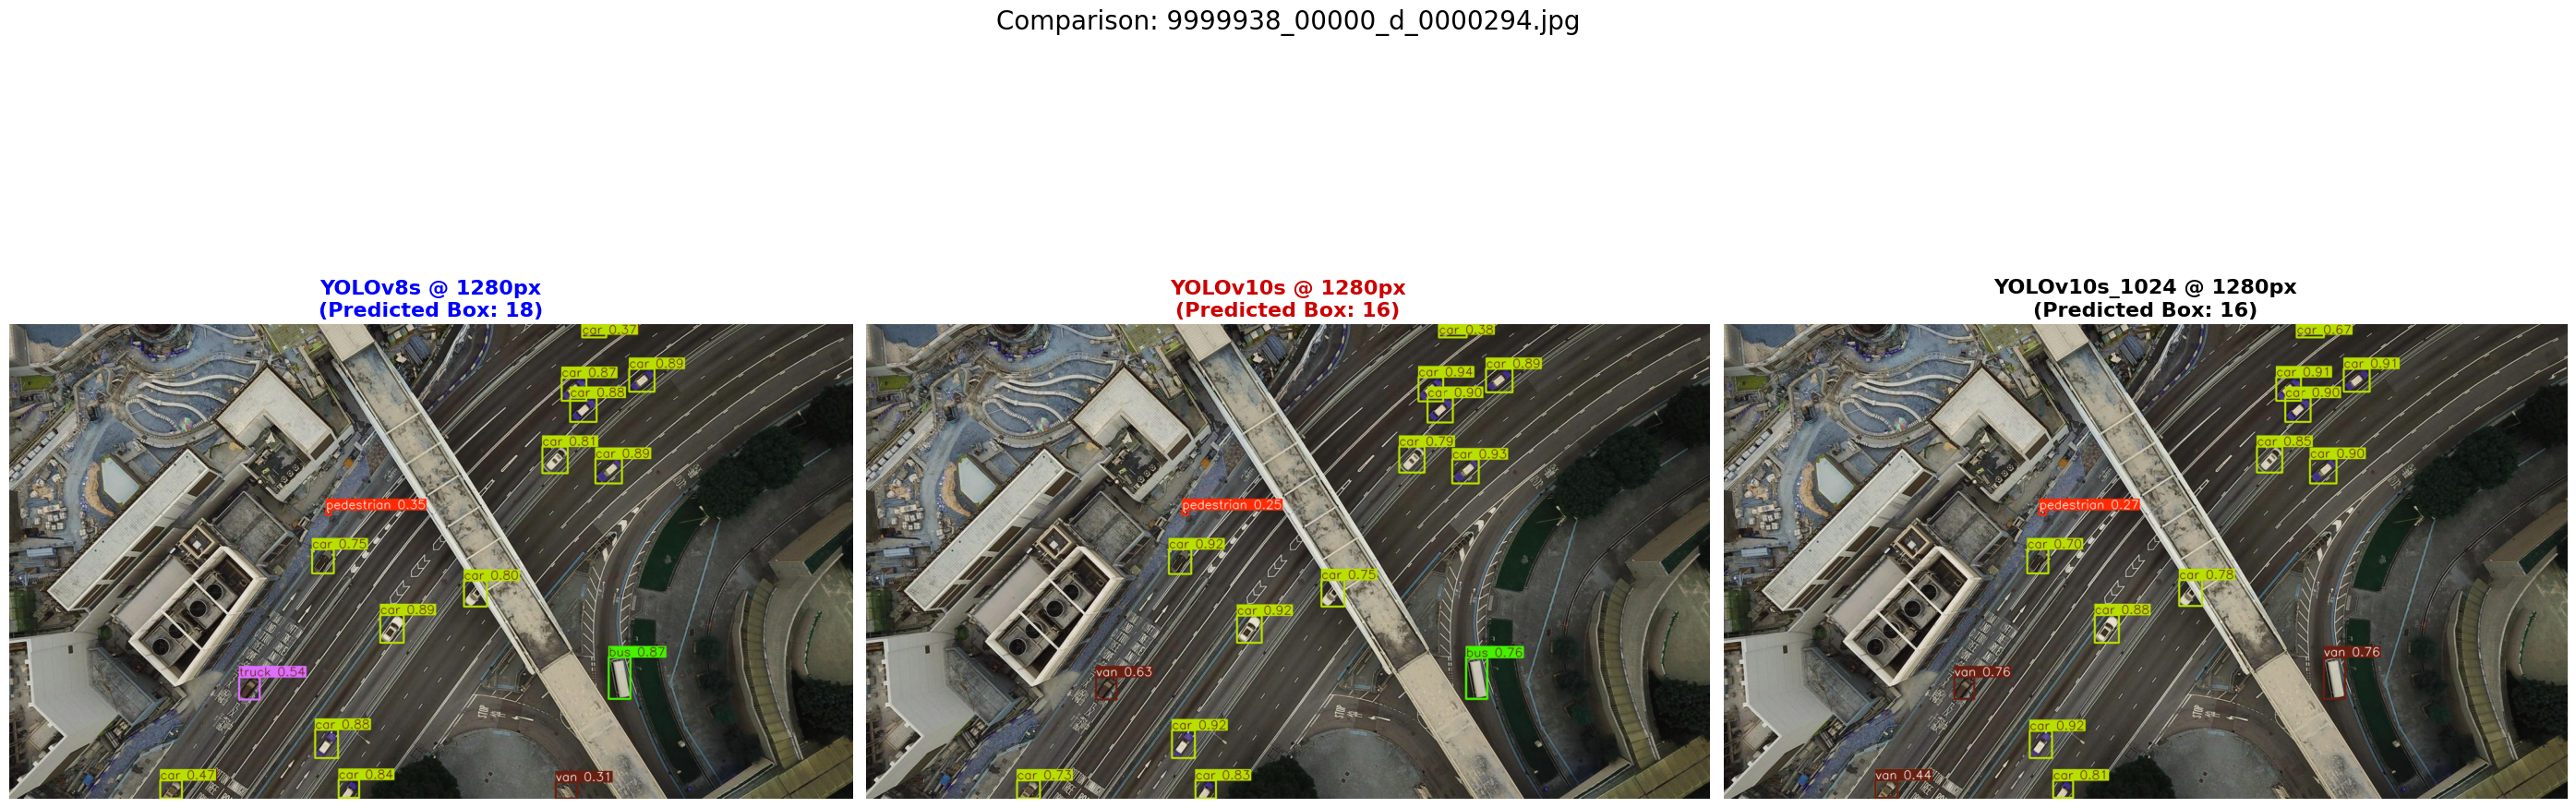

In [7]:
!pip install ultralytics
import matplotlib.pyplot as plt
import cv2
import numpy as np
import os
import random
from ultralytics import YOLO

# Configuration
model_v8_path = '/kaggle/input/pesiyolo-visdrone/v8small_100.pt'   
model_v10_path = '/kaggle/input/pesiyolo-visdrone/v10small_100.pt'
model_v10_1024path = '/kaggle/input/pesiyolo-visdrone/v10small_100_1024.pt'

images_dir = '/kaggle/working/datasets/VisDrone/VisDrone2019-DET-test-dev/images'

# Option to change the inference size
INFERENCE_SIZE = 1280  

def plot_comparison(img_path, model1, model2, model3, title1="YOLOv8s", title2="YOLOv10s", title3="YOLOv10s_1024"):
    
    img = cv2.imread(img_path)
    if img is None:
        print(f" Errore: Impossibile caricare {img_path}")
        return
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Model 1 (v8)
    print(f"\n {title1} Analysis:")
    res1 = model1.predict(img_path, conf=0.25, iou=0.45, imgsz=INFERENCE_SIZE, verbose=False)[0]
    plot1 = res1.plot(line_width=2, font_size=1) 
    
    unique, counts = np.unique(res1.boxes.cls.cpu().numpy(), return_counts=True)
    for cls_id, count in zip(unique, counts):
        print(f"   - {res1.names[int(cls_id)]}: {count}")

    # Model 2 (v10)
    print(f"\n {title2} Analysis:")
    res2 = model2.predict(img_path, conf=0.25, imgsz=INFERENCE_SIZE, verbose=False)[0]
    plot2 = res2.plot(line_width=2, font_size=1)
    
    unique, counts = np.unique(res2.boxes.cls.cpu().numpy(), return_counts=True)
    for cls_id, count in zip(unique, counts):
        print(f"   - {res2.names[int(cls_id)]}: {count}")

    # Model 3 (v10_1024)
    print(f"\n {title3} Analysis:")
    res3 = model3.predict(img_path, conf=0.25, imgsz=INFERENCE_SIZE, verbose=False)[0]
    plot3 = res3.plot(line_width=2, font_size=1)
    
    unique, counts = np.unique(res3.boxes.cls.cpu().numpy(), return_counts=True)
    for cls_id, count in zip(unique, counts):
        print(f"   - {res3.names[int(cls_id)]}: {count}")

    # Plot creation
    fig, axes = plt.subplots(1, 3, figsize=(28, 12)) 
    
    # Plot 1
    axes[0].imshow(plot1)
    axes[0].set_title(f"{title1} @ {INFERENCE_SIZE}px\n(Predicted Box: {len(res1.boxes)})", fontsize=16, fontweight='bold', color='blue')
    axes[0].axis('off')
    
    # Plot 2
    axes[1].imshow(plot2)
    axes[1].set_title(f"{title2} @ {INFERENCE_SIZE}px\n(Predicted Box: {len(res2.boxes)})", fontsize=16, fontweight='bold', color='#cc0000')
    axes[1].axis('off')

    # Plot 3
    axes[2].imshow(plot3)
    axes[2].set_title(f"{title3} @ {INFERENCE_SIZE}px\n(Predicted Box: {len(res3.boxes)})", fontsize=16, fontweight='bold', color='black')
    axes[2].axis('off')
    
    plt.suptitle(f"Comparison: {os.path.basename(img_path)}", fontsize=20)
    plt.tight_layout()
    plt.show()

# Execution
try:
    v8 = YOLO(model_v8_path)
    v10 = YOLO(model_v10_path)
    v10_1024 = YOLO(model_v10_1024path)
    
    if os.path.exists(images_dir):
        selected_img = "9999938_00000_d_0000294.jpg"
        full_path = os.path.join(images_dir, selected_img)
        
        if os.path.exists(full_path):
            print(f" Analisi immagine: {selected_img} con size {INFERENCE_SIZE}")
            plot_comparison(full_path, v8, v10, v10_1024)
        else:
            print(f" Immagine specifica non trovata: {selected_img}")
    else:
        print(f" Cartella non trovata: {images_dir}")

except Exception as e:
    print(f" Errore: {e}")

 Analisi immagine: 9999938_00000_d_0000043.jpg con size 1280


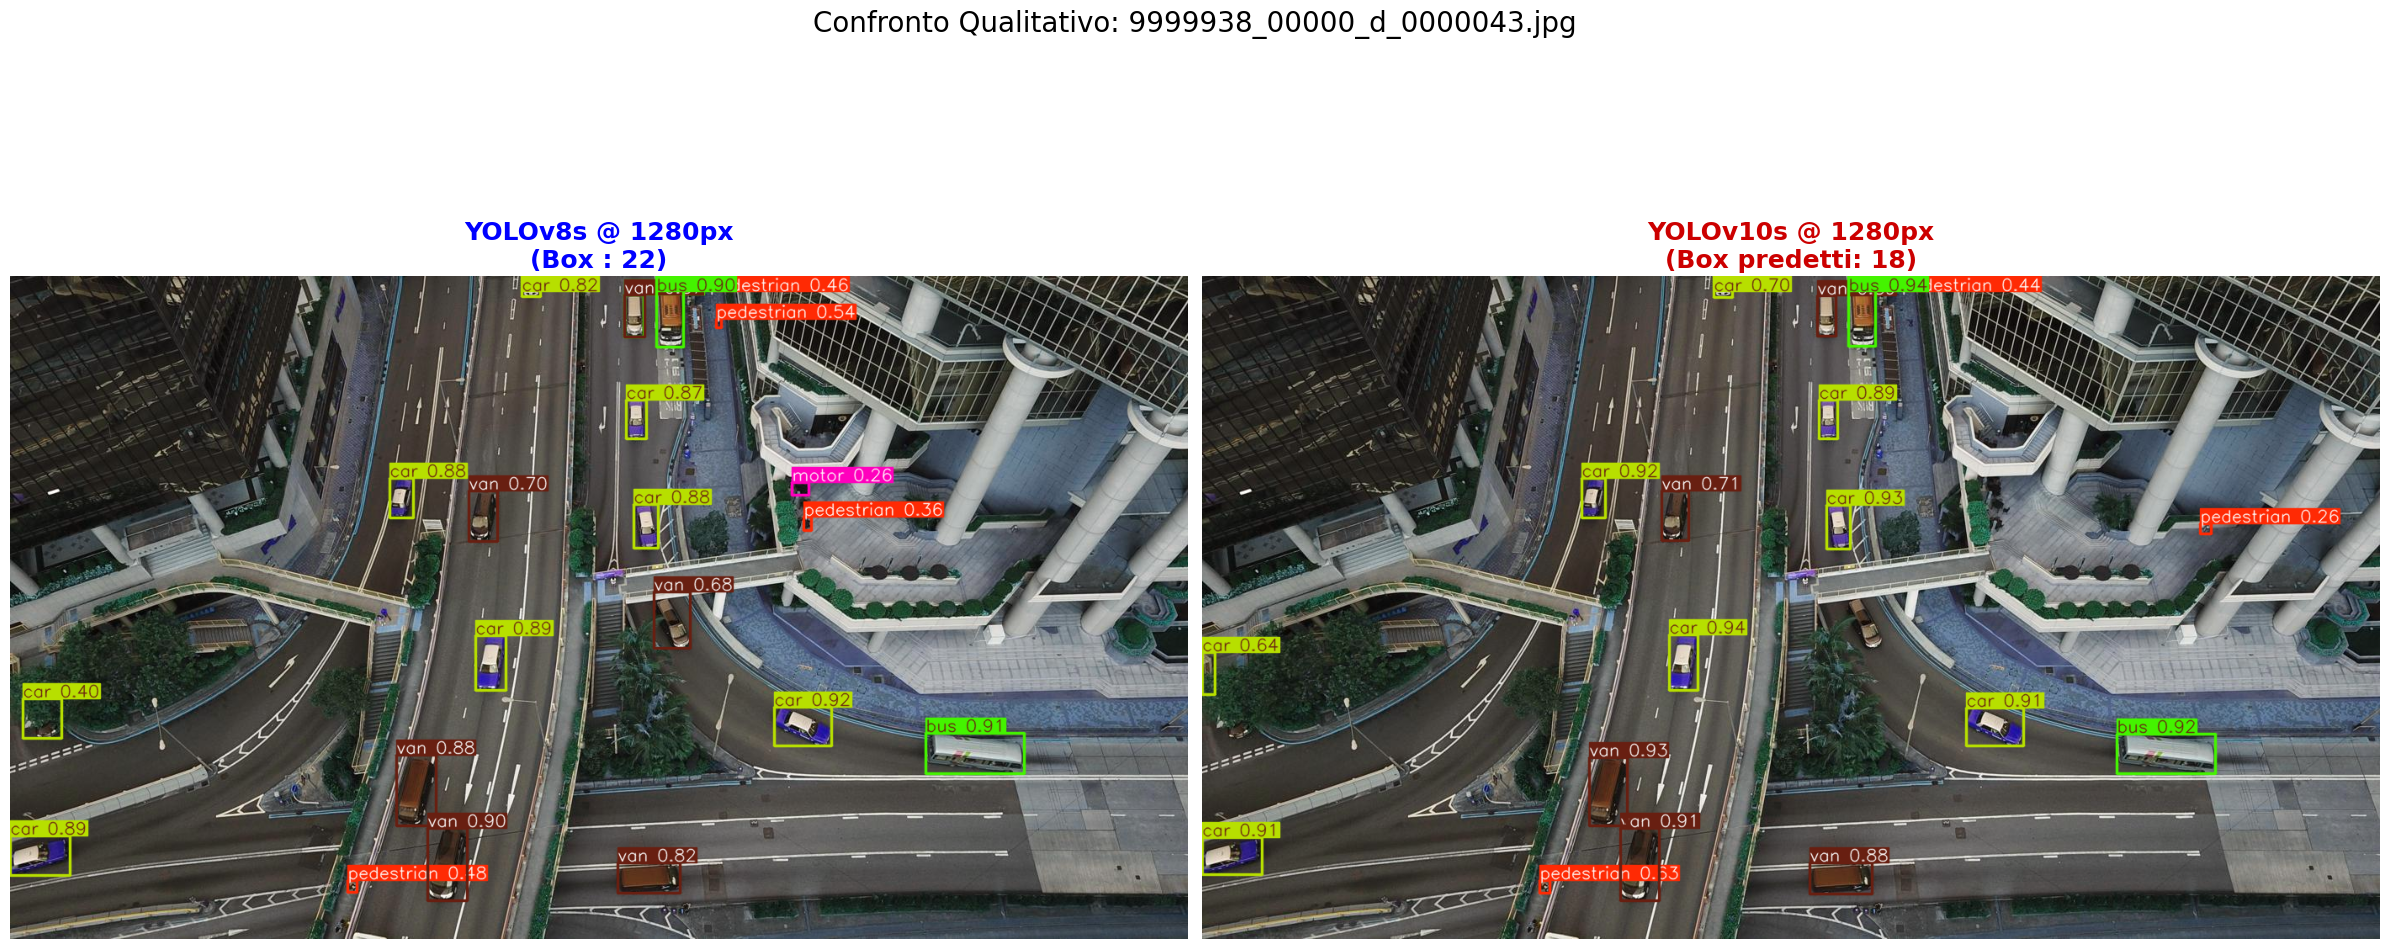

In [13]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
import os
import random
from ultralytics import YOLO

model_v8_path = '/kaggle/input/pesiyolo-visdrone/v8small_100.pt'   
model_v10_path = '/kaggle/input/pesiyolo-visdrone/v10small_100.pt'
images_dir = '/kaggle/working/datasets/VisDrone/VisDrone2019-DET-test-dev/images'

INFERENCE_SIZE = 1280  

def plot_comparison(img_path, model1, model2, title1="YOLOv8s", title2="YOLOv10s"):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    res1 = model1.predict(img_path, conf=0.25, iou=0.45, imgsz=INFERENCE_SIZE, verbose=False)[0]
    plot1 = res1.plot(line_width=2, font_size=1) 
    
    res2 = model2.predict(img_path, conf=0.25, imgsz=INFERENCE_SIZE, verbose=False)[0]
    plot2 = res2.plot(line_width=2, font_size=1)
    
    fig, axes = plt.subplots(1, 2, figsize=(24, 12)) 
    
    axes[0].imshow(plot1)
    axes[0].set_title(f"{title1} @ {INFERENCE_SIZE}px\n(Box : {len(res1.boxes)})", fontsize=18, fontweight='bold', color='blue')
    axes[0].axis('off')
    
    axes[1].imshow(plot2)
    axes[1].set_title(f"{title2} @ {INFERENCE_SIZE}px\n(Box predetti: {len(res2.boxes)})", fontsize=18, fontweight='bold', color='#cc0000')
    axes[1].axis('off')
    
    plt.suptitle(f"Confronto Qualitativo: {os.path.basename(img_path)}", fontsize=20)
    plt.tight_layout()
    plt.show()

try:
    v8 = YOLO(model_v8_path)
    v10 = YOLO(model_v10_path)
    
    if os.path.exists(images_dir):
        all_images = [f for f in os.listdir(images_dir) if f.endswith('.jpg')]
        
        if all_images:
            selected_img = random.choice(all_images)
            full_path = os.path.join(images_dir, selected_img)
            print(f" Analisi immagine: {selected_img} con size {INFERENCE_SIZE}")
            
            plot_comparison(full_path, v8, v10)
        else:
            print("Nessuna immagine .jpg trovata.")
    else:
        print(f" Cartella non trovata: {images_dir}")

except Exception as e:
    print(f" Errore: {e}")